# Logistic and linear regression with deterministic and stochastic first order methods

    Lab 3 : Optimisation - DataScience Master
    Authors : Robert Gower, Alexandre Gramfort
   
The aim of this lab is to implement and compare various batch and stochastic algorithms for linear and logistic with ridge penalization. 

The following methods are compared in this notebook.

**Batch (deterministic) methods**

- gradient descent (GD)
- accelerated gradient descent (AGD)
- L-BFGS
- conjugate gradient (CG)

**Stochastic algorithms**

- stochastic gradient descent (SGD)
- stochastic averaged gradient (SAG)
- stochastic variance reduced gradient (SVRG)

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with many other models, and other types of penalization, eventually non-smooth ones, such as the $\ell_1$ penalization.


## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 26th of november at 23:55**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

### How to construct the name of your file

In [348]:
# Change here using YOUR first and last names
fn1 = "oumayma"
ln1 = "bounou"
fn2 = "guillaume"
ln2 = "leveque"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab3_bounou_oumayma_and_leveque_guillaume.ipynb


# Gentle reminder: no evaluation if you don't respect this EXACTLY

### Table of content

[1. Loss functions, gradients and step-sizes](#loss)<br>
[2. Generate a dataset](#data)<br>
[3. Deterministic methods](#batch)<br>
[4. Stochastic methods](#stoc)<br>
[5. Numerical comparison](#comp)<br>
[6. Conclusion](#conc)<br>

In [349]:
%matplotlib inline

In [350]:
import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt

<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes


We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(x)
$$
where
$$
f_i(x) = \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2.
$$

For both cases, the gradients are
$$
\nabla f_i(x) = (a_i^\top x - b_i) a_i + \lambda x
$$
and
$$
\nabla f_i(x) = - \frac{b_i}{1 + \exp(b_i a_i^\top x)} a_i + \lambda x.
$$

Denote by $L$ (resp. $L_i$) the Lipschitz constant of $f$ (resp. $f_i$) and $\mathbf A^\top = [a_1, \ldots, a_n].$
One can easily see (using $\|\cdot\|_{2}$ for the matrix spectrale norm) that for linear regression
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{n} + \lambda \quad \text{ and } L_i = \| a_i \|_2^2 + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| a_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / (\max_{i=1,\ldots,n} L_i)$

We now introduce a class that will be used for the solvers.

In [351]:
from scipy.linalg import svd


class LinReg(object):
    """A class for the least-squares regression with L2/Ridge penalization"""

    def __init__(self, A, b, lbda):
        self.A = A
        self.b = b
        self.n, self.d = A.shape
        self.lbda = lbda

    def grad(self, x):
        return self.A.T.dot(self.A.dot(x) - self.b) / self.n + self.lbda * x

    def loss(self, x):
        return norm(self.A.dot(x) - self.b) ** 2 / (2. * self.n) + self.lbda * norm(x) ** 2 / 2.

    def grad_i(self, i, x):
        a_i = self.A[i]
        return (a_i.dot(x) - self.b[i]) * a_i + self.lbda * x

    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        return norm(self.A, ord=2) ** 2 / self.n + self.lbda

In [352]:
class LogReg(object):
    """A class for the logistic regression with L2/Ridge penalization"""

    def __init__(self, A, b, lbda):
        self.A = A
        self.b = b
        self.n, self.d = A.shape
        self.lbda = lbda
    
    def grad(self, x):
        bAx = self.b * np.dot(self.A, x)
        temp = 1. / (1. + np.exp(bAx))
        grad = - np.dot(self.A.T, self.b * temp) / self.n + self.lbda * x
        return grad

    def loss(self, x):
        bAx = self.b * np.dot(self.A, x)
        return np.mean(np.log(1. + np.exp(- bAx))) + self.lbda * norm(x) ** 2 / 2.
    
    def grad_i(self, i, x):
        grad = - self.A[i] * self.b[i] / (1. + np.exp(self.b[i] * np.dot(self.A[i], x)))
        grad += self.lbda * x
        return grad

    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        return norm(self.A, ord=2) ** 2 / (4. * self.n) + self.lbda

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [353]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(x, n, std=1., corr=0.5):
    """
    Simulation for the least-squares problem

    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    return A, b

In [354]:
def simu_logreg(x, n, std=1., corr=0.5):
    """
    Simulation for the logistic regression problem
    
    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size    
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """    
    A, b = simu_linreg(x, n, std=1., corr=0.5)
    return A, np.sign(b)

In [355]:
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

_A, _b = simu_linreg(x_model_truth, n, std=1., corr=0.7)
#_A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.7)

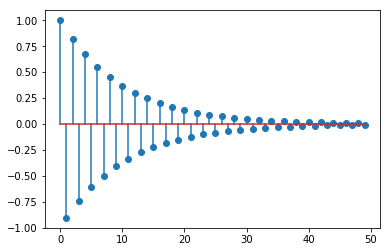

In [356]:
plt.stem(x_model_truth);

### Numerically check loss and gradient

In [357]:
from scipy.optimize import check_grad

lbda = 1. / n ** (0.5)
model = LinReg(_A, _b, lbda)

# Check that the gradient and the loss numerically match
check_grad(model.loss, model.grad, np.random.randn(d))

2.3651980249431494e-06

In [358]:
lbda = 1. / n ** (0.5)
model = LogReg(_A, _b, lbda)

# Check that the gradient and the loss numerically match
check_grad(model.loss, model.grad, np.random.randn(d))

1.9358382854862661e-07

### Choice of the model - LinReg

In [359]:
model = LinReg(_A, _b, lbda)
#model = LogReg(_A, _b, lbda)

### Compute the theoretical step-size for FISTA

In [360]:
from scipy.linalg import svd

step = 1. / model.lipschitz_constant()

print("step = %s" % step)

step = 0.176691102486


### Get a very precise minimum to compute distances to minimum

In [361]:
from scipy.optimize import fmin_l_bfgs_b
x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-30, factr=1e-30)

<a id='batch'></a> 

## 3. Deterministic methods (ISTA, FISTA, BFGS)

Before implementing GD, ISTA or FISTA we provide a simple function to be called after each iteration to gather and display a few metrics about the current minimization process.

In [362]:
import time

def inspector(loss_fun, x_real, verbose=False):
    """A closure called to update metrics after each iteration."""
    objectives = []
    errors = []
    t0 = time.time()
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    timing = [] 
    def inspector_cl(xk):
        obj = loss_fun(xk) - f_min
        err = norm(xk - x_min)
        tim = time.time()-t0
        objectives.append(obj)
        errors.append(err)
        timing.append(tim)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj", "err", "time"]]))
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8), ("%.4e" % tim).rjust(8)]))
            it[0] += 1
    inspector_cl.obj = objectives
    inspector_cl.err = errors
    inspector_cl.timing = timing

    return inspector_cl

In [363]:
# Number of iterations
n_iter = 50

### ISTA

We recall that an iteration of ISTA (actually a batch gradient here) writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the ISTA solver in the cell below

In [364]:
def ista(x_init, grad, n_iter=200, step=1., callback=None):
    """ISTA algorithm."""
    x = x_init.copy()
    for _ in range(n_iter):       
        x -= step * grad(x)
        
        # Update metrics after each iteration.
        if callback is not None: 
            callback(x)

    return x

In [365]:
step = 1. / model.lipschitz_constant()
x_init = np.zeros(d)
ista_inspector = inspector(model.loss, x_min, verbose=True)
x_ista = ista(x_init, model.grad, n_iter, step, callback=ista_inspector)

   it    |   obj    |   err    |   time  
       0 | 5.05e-01 | 2.16e+00 | 1.4551e-03
      10 | 2.23e-01 | 1.50e+00 | 1.1561e-02
      20 | 1.08e-01 | 1.05e+00 | 2.1241e-02
      30 | 5.35e-02 | 7.44e-01 | 3.1823e-02
      40 | 2.66e-02 | 5.26e-01 | 4.2895e-02


### FISTA

We recall that an iteration of FISTA (actually an accelerated batch gradient here) writes

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the FISTA solver in the cell below

In [366]:
def fista(x_init, grad, n_iter=100, step=1., callback=None):
    """FISTA algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.

    for _ in range(n_iter):
        
        x_new = y - step * grad(y)
        
        t_new = (1 + np.sqrt(1 + 4 * t**2))/2
        
        y = x_new + (t - 1)/t_new * (x_new - x)
        
        x = x_new
        t = t_new

        # Update metrics after each iteration.
        if callback is not None: 
            callback(x)
    return x

In [367]:
step = 1. / model.lipschitz_constant()
x_init = np.zeros(d)
fista_inspector = inspector(model.loss, x_min, verbose=True)
x_fista = fista(x_init, model.grad, n_iter, step, callback=fista_inspector)

   it    |   obj    |   err    |   time  
       0 | 5.05e-01 | 2.16e+00 | 1.4272e-03
      10 | 7.89e-02 | 9.03e-01 | 1.3203e-02
      20 | 9.34e-04 | 9.32e-02 | 2.3708e-02
      30 | 1.56e-03 | 1.28e-01 | 3.3193e-02
      40 | 3.42e-04 | 5.92e-02 | 4.1401e-02


### scipy.optimize's conjuguate gradient

Let's compare with ``scipy.optimize``'s conjuguate gradient solver.

In [368]:
# Conjugate gradient descent
from scipy.optimize import fmin_cg

x_init = np.zeros(d)
cg_inspector = inspector(model.loss, x_min, verbose=True)
x_cg = fmin_cg(model.loss, x_init, model.grad, maxiter=n_iter, callback=cg_inspector)

   it    |   obj    |   err    |   time  
       0 | 4.20e-01 | 1.95e+00 | 5.2719e-03
      10 | 6.91e-04 | 5.91e-02 | 2.5472e-02
      20 | 4.80e-07 | 1.46e-03 | 5.0562e-02
Optimization terminated successfully.
         Current function value: 0.523717
         Iterations: 30
         Function evaluations: 53
         Gradient evaluations: 53


### scipy.optimize's BFGS

Let's compare with ``scipy.optimize``'s BFGS solver

In [369]:
# Conjugate gradient descent
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
bfgs_inspector = inspector(model.loss, x_min, verbose=True)
x_bfgs, _, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, maxiter=n_iter, callback=bfgs_inspector)

   it    |   obj    |   err    |   time  
       0 | 4.20e-01 | 1.95e+00 | 5.3132e-03
      10 | 3.38e-04 | 4.88e-02 | 2.2558e-02
      20 | 1.06e-07 | 8.36e-04 | 3.8549e-02


### A first numerical comparison of deterministic solvers

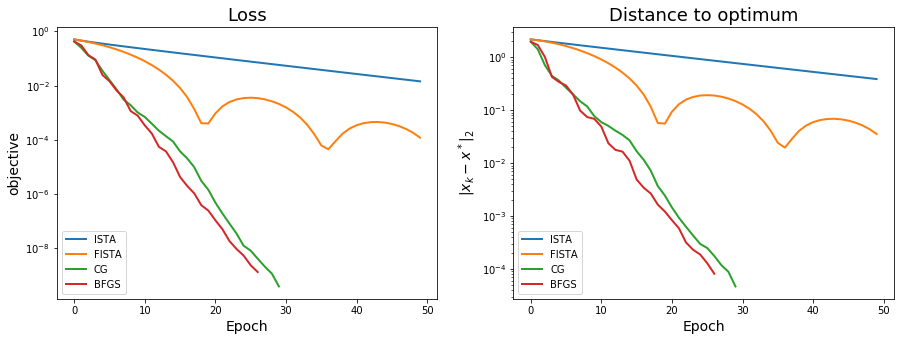

In [370]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector]

solvers = ["ISTA", "FISTA", "CG", "BFGS"]

for insp in inspectors:
    plt.semilogy(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("objective", fontsize=14)

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.semilogy(insp.err, lw=2)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)

plt.legend(solvers);

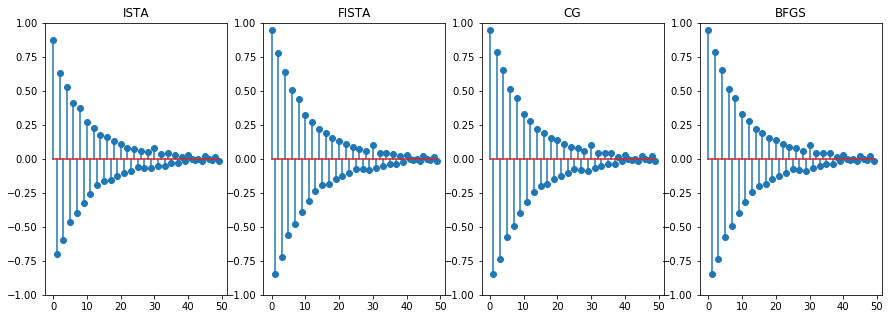

In [371]:
plt.figure(figsize=(15, 5))

xs = [x_ista, x_fista, x_cg, x_bfgs]

for i, name, x in zip(range(1, 5), solvers, xs):
    plt.subplot(1, 4, i)
    plt.stem(x)
    plt.ylim([-1, 1])
    plt.title(name)

### First conclusions 

*QUESTIONS*:

- Give some first conclusions about the batch solver studied here
- What do you observe about FISTA? is it suprising ?

### Conclusions for linear regression
#### We notice that ISTA is always faster than ISTA (except maybe at the very first iterations). Also, CG and BFGS converge much faster than ISTA and FISTA, and to a much precise minimum (and minimizer).
#### Moreover, we notice that FISTA is not constantly decreasing, which is not surprising because it's not a descent algorithm.

<a id='stoc'></a> 
## 4. Stochastic methods

In [372]:
n_iter = 50

# generate indices of random samples
iis = np.random.randint(0, n, n * n_iter)  

### SGD

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

*QUESTION*:
- Fill in the iteration of the SGD solver in the cell below

In [373]:
def sgd(x_init, iis, grad_i, n_iter=100, step=1., callback=None):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    
    for idx in range(n_iter):
        i = iis[idx]
          
        x -= step/np.sqrt(idx + 1) * grad_i(i, x)
    
        # Update metrics after each iteration.
        if callback is not None and idx % n == 0:
            callback(x)
    return x

In [374]:
step0 = 0.02
x_init = np.zeros(d)
sgd_inspector = inspector(model.loss, x_min, verbose=True)
x_sgd = sgd(x_init, iis, model.grad_i, n * n_iter, step=step0, callback=sgd_inspector)

   it    |   obj    |   err    |   time  
       0 | 6.25e-01 | 2.25e+00 | 1.3044e-02
      10 | 4.50e-03 | 2.02e-01 | 8.4437e-01
      20 | 1.24e-03 | 8.53e-02 | 1.6820e+00
      30 | 5.14e-04 | 4.82e-02 | 2.5250e+00
      40 | 5.55e-04 | 4.39e-02 | 3.4011e+00


### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SAG solver in the cell below

In [375]:
def sag(x_init, iis, grad_i, n_iter=100, step=1., callback=None):
    """Stochastic average gradient algorithm."""
    x = x_init.copy()
    # Old gradients
    gradient_memory = np.zeros((n, d))
    y = np.zeros(d)
    G = np.mean(gradient_memory, axis=0)

    for idx in range(n_iter):
        i = iis[idx]
        
        y = gradient_memory[i].copy()
        gradient_memory[i] = grad_i(i, x)
        
        G += (gradient_memory[i] - y) / n
        x -= step * G
        
        
        
        # Update metrics after each iteration.
        if callback is not None and idx % n == 0:
            callback(x)
    return x

In [376]:
max_squared_sum = np.max(np.sum(model.A ** 2, axis=1))

if isinstance(model, LogReg):
    step = 4.0 / (max_squared_sum + 4.0 * model.lbda )
else:
    step = 1.0 / (max_squared_sum + model.lbda)

x_init = np.zeros(d)
sag_inspector = inspector(model.loss, x_min, verbose=True)
x_sag = sag(x_init, iis, model.grad_i, n * n_iter, step, callback=sag_inspector)

   it    |   obj    |   err    |   time  
       0 | 5.84e-01 | 2.25e+00 | 9.9599e-03
      10 | 1.27e-03 | 5.13e-02 | 1.1496e+00
      20 | 6.12e-06 | 3.84e-03 | 2.3146e+00
      30 | 3.02e-08 | 2.50e-04 | 3.4543e+00
      40 | 4.11e-10 | 2.45e-05 | 5.0989e+00


### SVRG

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
    4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
    5. Apply the step 
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big) 
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SVRG solver in the cell below

In [377]:
def svrg(x_init, iis, grad, grad_i, n_iter, step, callback=None):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_old = x.copy()
    
    for idx in range(n_iter):
        mu = grad(x_old)
        for t in range(n):
            i = iis[idx * n + t]
            x -= step * (grad_i(i, x) - grad_i(i, x_old) + mu)
        x_old = x.copy()

        
        # Update metrics after each full pass on data.
        if callback is not None:
            callback(x)
    return x

In [378]:
max_squared_sum = np.max(np.sum(model.A ** 2, axis=1))

if isinstance(model, LogReg):
    step = 4.0 / (max_squared_sum + 4.0 * model.lbda)
else:
    step = 1.0 / (max_squared_sum + model.lbda)
    
    
x_init = np.zeros(d)
svrg_inspector = inspector(model.loss, x_min, verbose=True)    
x_svrg = svrg(x_init, iis, model.grad, model.grad_i, n_iter, step, callback=svrg_inspector)

   it    |   obj    |   err    |   time  
       0 | 7.86e-02 | 4.73e-01 | 1.4950e-01
      10 | 1.92e-08 | 1.99e-04 | 1.3881e+00
      20 | 2.89e-15 | 6.68e-08 | 2.6239e+00
      30 | -2.22e-16 | 2.88e-08 | 3.7582e+00
      40 | -1.11e-16 | 2.88e-08 | 5.0198e+00


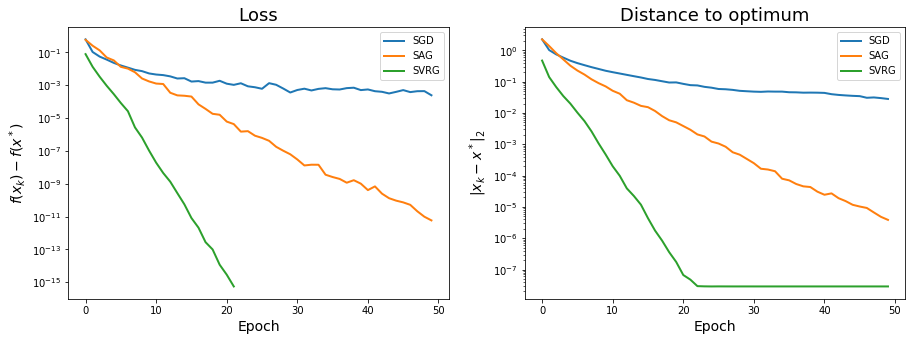

In [379]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [sgd_inspector, sag_inspector, svrg_inspector]

solvers = ["SGD", "SAG", "SVRG"]

for insp in inspectors:
    plt.semilogy(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.semilogy(insp.err, lw=2)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)

plt.legend(solvers);

<a id='comp'></a> 
## 5. Numerical comparison

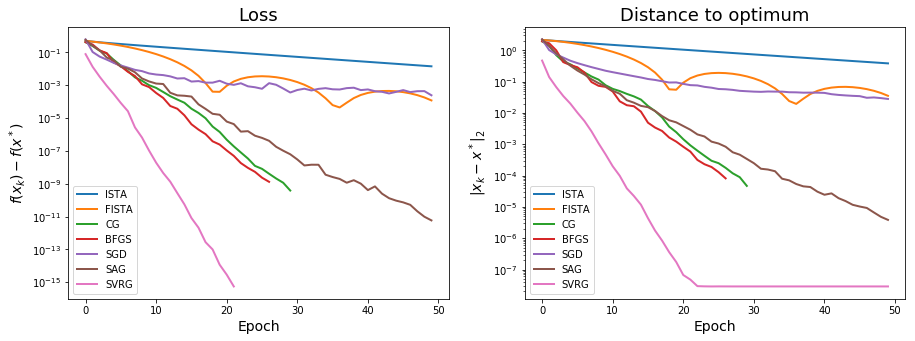

In [380]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector,
              sgd_inspector, sag_inspector, svrg_inspector]

solvers = ["ISTA", "FISTA", "CG", "BFGS", "SGD", "SAG", "SVRG"]

for insp in inspectors:
    plt.semilogy(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.semilogy(insp.err, lw=2)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)

plt.legend(solvers);

<a id='conc'></a>
## 6. Conclusion

*QUESTIONS*:
- Compare and comment your results
- Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1 / \sqrt n$ and compare your results. Comment.
- Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.
- Conclude

- Compare and comment your results
#### SVRG seems to be the algorithm with the highest precision, both for estimating the objective and the minimizer. Also, it's the fastest.
#### SGD is faster than ISTA, FISTA, CG, BFGS and SAG for the first 10 iterations, but after that, it goes the same speed as FISTA. It can be useful if what we're trying to do is estimate the minimum fast without being to demanding in terms of accuracy.
#### SAG also allows reaching precise minimum and minizer relatively fast. CG and BFGS (non-stochastic methods) perform better than SAG.
#### Within the stochastic methods, we notice that SVRG and SAG perform better than SGD, and that is because they do a variance reduction.

- Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1 / \sqrt n$ and compare your results. Comment.
#### We just saw the results with $\lambda = 1 / \sqrt n$, let's now change $\lambda$ to $1 / n$

Optimization terminated successfully.
         Current function value: 0.504671
         Iterations: 32
         Function evaluations: 60
         Gradient evaluations: 60


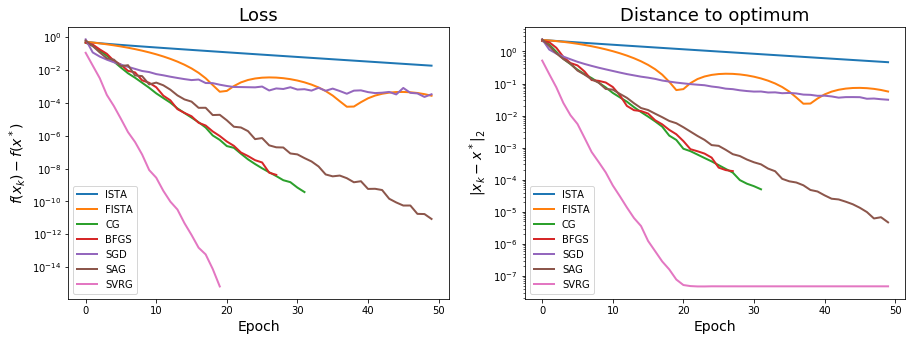

In [381]:
lbda = 1./n
corr = 0.7
# Define the model
_A, _b = simu_linreg(x_model_truth, n, std=1., corr=corr)
model = LinReg(_A, _b, lbda)

# Create the inspectors

## Step for ISTA and FISTA
step = 1. / model.lipschitz_constant()

#ISTA
x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-30, factr=1e-30)
ista_inspector = inspector(model.loss, x_min, verbose=False)
x_ista = ista(x_init, model.grad, n_iter, step, callback=ista_inspector)

#FISTA
x_init = np.zeros(d)
fista_inspector = inspector(model.loss, x_min, verbose=False)    
x_fista = fista(x_init, model.grad, n_iter, step, callback=fista_inspector)

#CG
x_init = np.zeros(d)
cg_inspector = inspector(model.loss, x_min, verbose=False)    
x_cg = fmin_cg(model.loss, x_init, model.grad, maxiter=n_iter, callback=cg_inspector)

#BFGS
x_init = np.zeros(d)
bfgs_inspector = inspector(model.loss, x_min, verbose=False)
x_bfgs, _, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, maxiter=n_iter, callback=bfgs_inspector)

#SGD
x_init = np.zeros(d)
step0 = 0.02
sgd_inspector = inspector(model.loss, x_min, verbose=False)
x_sgd = sgd(x_init, iis, model.grad_i, n * n_iter, step=step0, callback=sgd_inspector)

## step for SAG
max_squared_sum = np.max(np.sum(model.A ** 2, axis=1))
if isinstance(model, LogReg):
    step = 4.0 / (max_squared_sum + 4.0 * model.lbda )
else:
    step = 1.0 / (max_squared_sum + model.lbda)

#SAG
x_init = np.zeros(d)
sag_inspector = inspector(model.loss, x_min, verbose=False)
x_sag = sag(x_init, iis, model.grad_i, n * n_iter, step, callback=sag_inspector)

## Step for SVRG
max_squared_sum = np.max(np.sum(model.A ** 2, axis=1))
if isinstance(model, LogReg):
    step = 4.0 / (max_squared_sum + 4.0 * model.lbda)
else:
    step = 1.0 / (max_squared_sum + model.lbda)

#SVRG
x_init = np.zeros(d)
svrg_inspector = inspector(model.loss, x_min, verbose=False)    
x_svrg = svrg(x_init, iis, model.grad, model.grad_i, n_iter, step, callback=svrg_inspector)

## Plot and comparison

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector,
          sgd_inspector, sag_inspector, svrg_inspector]

solvers = ["ISTA", "FISTA", "CG", "BFGS", "SGD", "SAG", "SVRG"]

for insp in inspectors:
    plt.semilogy(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.semilogy(insp.err, lw=2)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)

plt.legend(solvers);


#### We notice that overall, there is no change in the shape of the loss or distance to optimum graphs for all the algorithms. But when we look more closely into the time to convergence, we notice that SVRG is a bit slower when $n = 1/n$ (loss is 10^-15 in 20 iterations with $n = 1/n$ versus 10^-16 with $\lambda = 1 / \sqrt n$

- Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.

Optimization terminated successfully.
         Current function value: 0.517685
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.505475
         Iterations: 22
         Function evaluations: 34
         Gradient evaluations: 34
         Current function value: 0.521412
         Iterations: 50
         Function evaluations: 83
         Gradient evaluations: 83


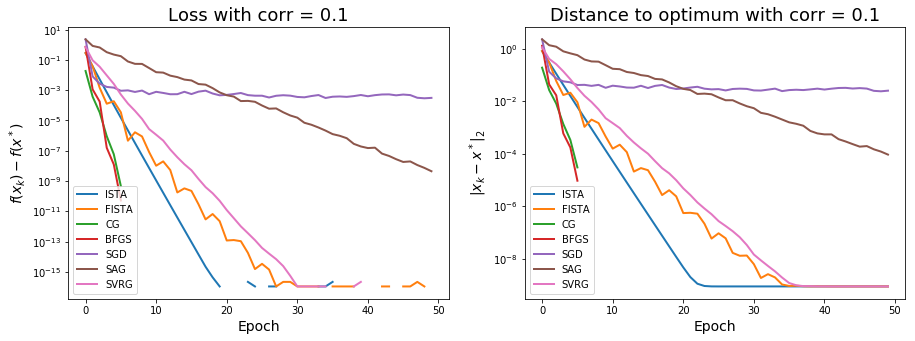

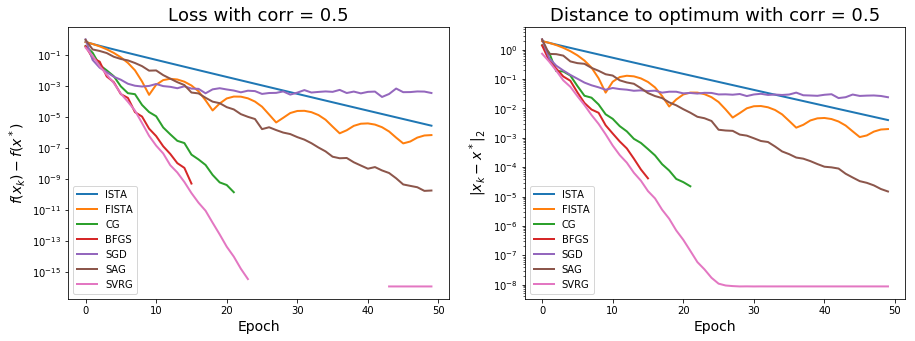

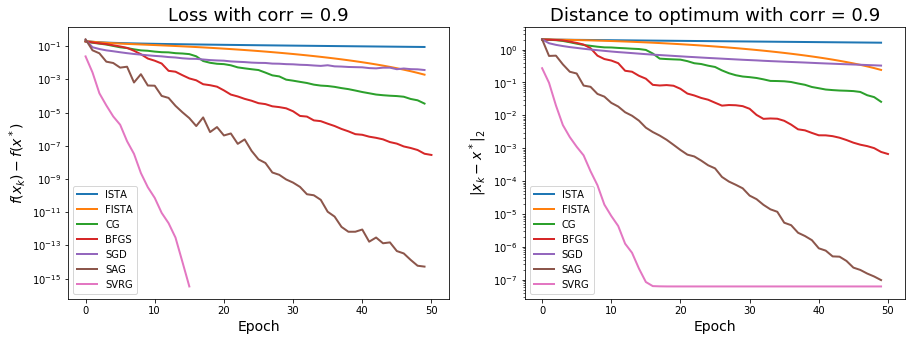

In [382]:
corr_list = [0.1, 0.5, 0.9]

lbda = 1. / n ** (1./2)

for corr in corr_list:
    # Define the model
    _A, _b = simu_linreg(x_model_truth, n, std=1., corr=corr)
    model = LinReg(_A, _b, lbda)

    # Create the inspectors

    ## Step for ISTA and FISTA
    step = 1. / model.lipschitz_constant()

    #ISTA
    x_init = np.zeros(d)
    x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-30, factr=1e-30)
    ista_inspector = inspector(model.loss, x_min, verbose=False)
    x_ista = ista(x_init, model.grad, n_iter, step, callback=ista_inspector)

    #FISTA
    x_init = np.zeros(d)
    fista_inspector = inspector(model.loss, x_min, verbose=False)    
    x_fista = fista(x_init, model.grad, n_iter, step, callback=fista_inspector)

    #CG
    x_init = np.zeros(d)
    cg_inspector = inspector(model.loss, x_min, verbose=False)    
    x_cg = fmin_cg(model.loss, x_init, model.grad, maxiter=n_iter, callback=cg_inspector)

    #BFGS
    x_init = np.zeros(d)
    bfgs_inspector = inspector(model.loss, x_min, verbose=False)
    x_bfgs, _, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, maxiter=n_iter, callback=bfgs_inspector)

    #SGD
    x_init = np.zeros(d)
    step0 = 0.02
    sgd_inspector = inspector(model.loss, x_min, verbose=False)
    x_sgd = sgd(x_init, iis, model.grad_i, n * n_iter, step=step0, callback=sgd_inspector)

    ## step for SAG
    max_squared_sum = np.max(np.sum(model.A ** 2, axis=1))
    if isinstance(model, LogReg):
        step = 4.0 / (max_squared_sum + 4.0 * model.lbda )
    else:
        step = 1.0 / (max_squared_sum + model.lbda)

    #SAG
    x_init = np.zeros(d)
    sag_inspector = inspector(model.loss, x_min, verbose=False)
    x_sag = sag(x_init, iis, model.grad_i, n * n_iter, step, callback=sag_inspector)

    ## Step for SVRG
    max_squared_sum = np.max(np.sum(model.A ** 2, axis=1))
    if isinstance(model, LogReg):
        step = 4.0 / (max_squared_sum + 4.0 * model.lbda)
    else:
        step = 1.0 / (max_squared_sum + model.lbda)

    #SVRG
    x_init = np.zeros(d)
    svrg_inspector = inspector(model.loss, x_min, verbose=False)    
    x_svrg = svrg(x_init, iis, model.grad, model.grad_i, n_iter, step, callback=svrg_inspector)

    ## Plot and comparison

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)

    inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector,
              sgd_inspector, sag_inspector, svrg_inspector]

    solvers = ["ISTA", "FISTA", "CG", "BFGS", "SGD", "SAG", "SVRG"]

    for insp in inspectors:
        plt.semilogy(insp.obj, lw=2)
        plt.title("Loss with corr = {0}".format(corr), fontsize=18)
        plt.xlabel("Epoch", fontsize=14)
        plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)

    plt.legend(solvers)

    plt.subplot(1, 2, 2)

    for insp in inspectors:
        plt.semilogy(insp.err, lw=2)
        plt.title("Distance to optimum with corr = {0}".format(corr), fontsize=18)
        plt.xlabel("Epoch", fontsize=14)
        plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)

    plt.legend(solvers);

#### We notice that when the correlation is low, ISTA and FISTA are very performant in terms of precision and speed of convergence. The higher the correlation, the poorer the estimation for these two algorithms.

#### BFGS and CG 's performance decreases when the correlation increases.

#### Stochastic methods on the other side seem to be even more performant with a high correlation (especially SVRG and SAG, for SGD's performance doesn't seem to vary). 

### Overall conclusion

#### ISTA, FISTA, BFGS and CG seem to be quite sensitive to conditioning, especially to correlation. Stochastic methods are more robust, especially to correlation. But they're usually more expensive.